In [1]:
import os
import pywt
import torch
import pickle
import numpy as np
from scipy.signal import resample
from pathlib import Path


In [2]:
file_model = open('xgb_model_2025_4_level_GPU.pkl', 'rb')
xgb_clf = pickle.load(file_model)
X_test = np.load('X_test_values_DWT_2025_4_level.npy')
y_pred = xgb_clf.predict(X_test)

# Hamming Loss
print("Hamming Loss:",type(X_test), X_test.shape, y_pred.shape, max(y_pred))

Hamming Loss: <class 'numpy.ndarray'> (28305, 126) (28305,) 5


/home/eshuranov/miniconda3/envs/labram2/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:35:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444540481/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [4]:
print(min(y_pred))

0


In [2]:
from epilepsy2bids.annotations import Annotations
from epilepsy2bids.eeg import Eeg
from mne.io import RawArray
import mne

ModuleNotFoundError: No module named 'epilepsy2bids'

### One file process

In [ ]:
train_data = "/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage"

In [5]:
test_file = "/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/eval/aaaaaadd_00000005-0.pkl"

In [6]:
sample = pickle.load(open(os.path.join(test_file), "rb"))

X = sample["signal"]
coeffs = pywt.wavedec2(X, wavelet='haar', level=4)  # Perform discrete Haar wavelet transform
X = coeffs[0]
Y = int(sample["label"][0] - 1)

In [7]:
print(X.shape)

(2, 63)


In [8]:
print(Y)

5


### Data processing

In [9]:
train_files = os.listdir("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/train")
eval_files = os.listdir("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/eval")
test_files = os.listdir("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/test")

In [10]:
class TUEVLoader(torch.utils.data.Dataset):
    def __init__(self, root, files, sampling_rate=200):
        self.root = root
        self.files = files
        self.default_rate = 200
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        sample = pickle.load(open(os.path.join(self.root, self.files[index]), "rb"))
        X = sample["signal"]
        if self.sampling_rate != self.default_rate:
            X = resample(X, 5 * self.sampling_rate, axis=-1)
        
        coeffs = pywt.wavedec2(X, wavelet='haar', level=4)  # Perform discrete Haar wavelet transform
        X = coeffs[0]
        Y = int(sample["label"][0] - 1)
        
        return X, Y
    

def prepare_TUEV_dataset():
    # set random seed
    seed = 4523
    np.random.seed(seed)

    # path to train, val, test files. Might need to be changed depending on your file organisation
    train_files = os.listdir("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/train")
    val_files = os.listdir("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/eval")
    test_files = os.listdir("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/test")

    # prepare training and test data loader
    train_dataset = TUEVLoader(
        os.path.join("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/train"), train_files
    )
    test_dataset = TUEVLoader(
        os.path.join("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/test"), test_files
    )
    val_dataset = TUEVLoader(
        os.path.join("/media/public/Datasets/TUEV/tuev/edf/processed_sz_chalenge_2025_montage/eval"), val_files
    )
    print(len(train_files), len(test_files), len(val_files))
    return train_dataset, test_dataset, val_dataset

In [11]:
def get_TUEV_dataset():
    train_dataset, test_dataset, val_dataset = prepare_TUEV_dataset()
    ch_names = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', \
                'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG T1-REF', 'EEG T2-REF']
    ch_names_after_convert = ['FP1-F7', 'F7-T3', 'T3-T5', 'T5-O1',
                              'FP2-F8', 'F8-T4', 'T4-T6', 'T6-O2',
                              'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
                              'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2']

    new_ch_names = ["FP1-F7", "F7-T7", "T7-P7", "P7-O1",
                    "FP2-F8", "F8-T8", "T8-P8", "P8-O2",
                    "FP1-F3", "F3-C3", "C3-P3", "P3-O1",
                    "FP2-F4", "F4-C4", "C4-P4", "P4-O2"]

    new_ch_names_to_128 = ["FP1-F7", "F7-T7", "T7-P7", "P7-O1",
                    "FP2-F8", "F8-T8", "T8-P8", "P8-O2"]


    ch_names = [name.split(' ')[-1].split('-')[0] for name in ch_names_after_convert]
    # args.nb_classes = 6
    metrics = ["accuracy", "balanced_accuracy", "cohen_kappa"]
    return train_dataset, test_dataset, val_dataset, new_ch_names_to_128, metrics

In [12]:
dataset_train, dataset_test, dataset_val, ch_names, metrics = get_TUEV_dataset()

66873 28305 17059


In [13]:
X_list, y_list = [], []
for X_batch, y_batch in dataset_train:
    X_list.append(X_batch)
    y_list.append(y_batch)

In [14]:
print(len(X_list))
print(len(X_list[0]))

66873
2


In [15]:
print(len(X_list[0][0]))

63


In [16]:
X_list_test, y_list_test = [], []
for X_batch, y_batch in dataset_test:
    X_list_test.append(X_batch)
    y_list_test.append(y_batch)
    

In [17]:
print(len(X_list_test))
print(len(X_list_test[0]))

28305
2


In [18]:
X_list_eval, y_list_eval = [], []
for X_batch, y_batch in dataset_val:
    X_list_eval.append(X_batch)
    y_list_eval.append(y_batch)    
    

In [19]:
print(len(X_list_eval))
print(len(X_list_eval[0]))

17059
2


In [20]:
tmp = np.array(X_list)
print(tmp.shape)
X_list = tmp.reshape(66873, 126)
print(X_list.shape)
y_list = np.array(y_list)
print(y_list.shape)

(66873, 2, 63)
(66873, 126)
(66873,)


In [21]:
tmp = np.array(X_list_test)
print(tmp.shape)
X_list_test = tmp.reshape(28305, 126)
print(X_list_test.shape)
y_list_test = np.array(y_list_test)
print(y_list_test.shape)

(28305, 2, 63)
(28305, 126)
(28305,)


In [22]:
tmp = np.array(X_list_eval)
X_list_eval = tmp.reshape(17059, 126)
print(X_list_eval.shape)
y_list_eval = np.array(y_list_eval)
print(y_list_eval.shape)

(17059, 126)
(17059,)


In [23]:
np.save("X_train_values_DWT_2025_4_level.npy", X_list)
np.save("y_train_values_DWT_2025_4_level.npy", y_list)

np.save("X_test_values_DWT_2025_4_level.npy", X_list_test)
np.save("y_test_values_DWT_2025_4_level.npy", y_list_test)

np.save("X_val_values_DWT_2025_4_level.npy", X_list_eval)
np.save("y_val_values_DWT_2025_4_level.npy", y_list_eval)

# XGBoost

In [24]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, hamming_loss, accuracy_score, classification_report, precision_recall_fscore_support, balanced_accuracy_score

In [26]:
X_train = np.load('X_train_values_DWT_2025_4_level.npy')
y_train = np.load('y_train_values_DWT_2025_4_level.npy')

In [27]:
X_test = np.load('X_test_values_DWT_2025_4_level.npy')
y_test = np.load('y_test_values_DWT_2025_4_level.npy')

In [28]:
X_eval = np.load('X_val_values_DWT_2025_4_level.npy')
y_eval = np.load('y_val_values_DWT_2025_4_level.npy')

In [ ]:
file_model = open('xgb_model_2025_4_level_GPU.pkl', 'rb')
xgb_clf = pickle.load(file_model)
y_pred = xgb_clf.predict(X_test)

# Hamming Loss
print("Hamming Loss:", hamming_loss(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
# report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(y_test.shape[1])])
# print("Classification Report:\n", report)

# Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


In [6]:
# Classification Report
report = classification_report(y_test, y_pred, target_names=['spsw', 'gped', 'pled', 'eyem', 'artf', 'backg'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        spsw       0.00      0.00      0.00       567
        gped       0.32      0.23      0.27      3561
        pled       0.22      0.27      0.25      1998
        eyem       0.13      0.12      0.13       329
        artf       0.08      0.05      0.06      2204
       backg       0.79      0.87      0.83     19646

    accuracy                           0.66     28305
   macro avg       0.26      0.26      0.26     28305
weighted avg       0.61      0.66      0.63     28305



In [7]:
eval_predict = xgb_clf.predict(X_eval)
eval_report = classification_report(y_eval, eval_predict, target_names=['spsw', 'gped', 'pled', 'eyem', 'artf', 'backg'])
print("Classification Report:\n", eval_report)

Classification Report:
               precision    recall  f1-score   support

        spsw       0.00      0.00      0.00        45
        gped       0.43      0.49      0.46      1648
        pled       0.59      0.40      0.47      2730
        eyem       0.14      0.32      0.20       208
        artf       0.38      0.21      0.27      2148
       backg       0.80      0.91      0.86     10280

    accuracy                           0.69     17059
   macro avg       0.39      0.39      0.38     17059
weighted avg       0.67      0.69      0.67     17059



In [8]:
group_1 = {1, 2, 3}  # Group 1 (mapped to 0)
group_2 = {4, 5, 6}  # Group 2 (mapped to 1)

true_labels = [0 if cls in group_1 else 1 for cls in y_test]
predicted_labels = [0 if cls in group_1 else 1 for cls in y_pred]

balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)
print("Balanced Accuracy:", balanced_acc)

Balanced Accuracy: 0.7136291736994537


### ROC-AUC curve based on the maximum probability

In [77]:
train_pred = xgb_clf.predict(X_train)

true_train_labels = [0 if cls in group_1 else 1 for cls in y_train]
# predicted_train_labels = [0 if cls in group_1 else 1 for cls in train_pred]

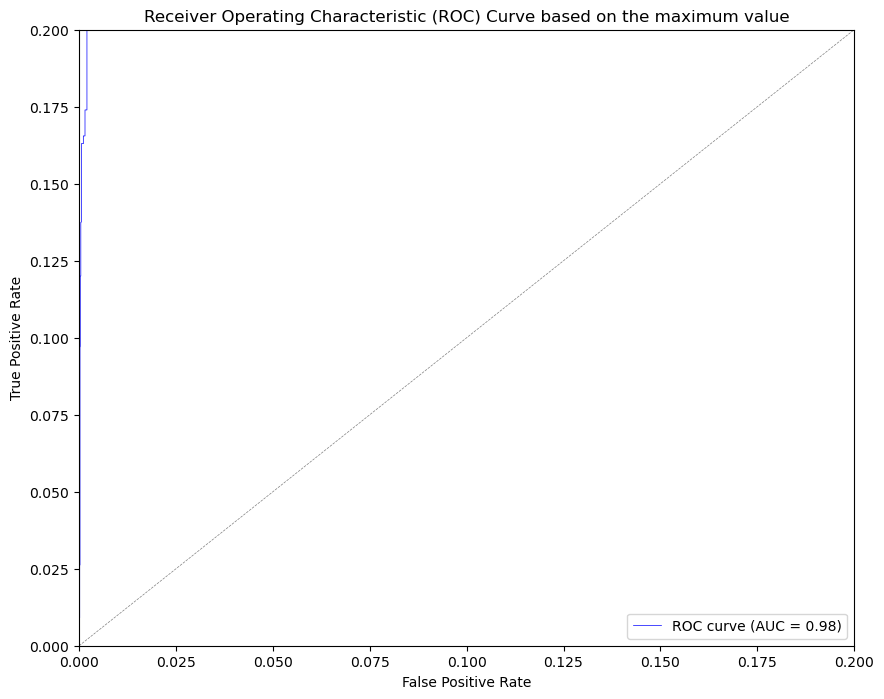

In [78]:
raw_scores = xgb_clf.predict_proba(X_train)
y_scores = np.array([max(probs[3:]) / (max(probs[:3]) + max(probs[3:])) for probs in raw_scores])

fpr, tpr, _ = roc_curve(true_train_labels, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=0.5, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0.0, 1.0], [0.0, 1.0], lw=0.5,color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 0.2])
plt.ylim([0.0, 0.2])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve based on the maximum value')
plt.legend(loc='lower right')
plt.show()

### Optimised Treshold for the TP > 0.99

In [79]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(true_train_labels, y_scores)

valid_indices = np.where(fpr <= 0.01)[0]

optimal_idx = valid_indices[np.argmax(tpr[valid_indices])]
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}, TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

Optimal Threshold: 0.9834, TPR: 0.5057, FPR: 0.0100


### Balanced Accuracy and Confusion matrix with the treshold on the train and test

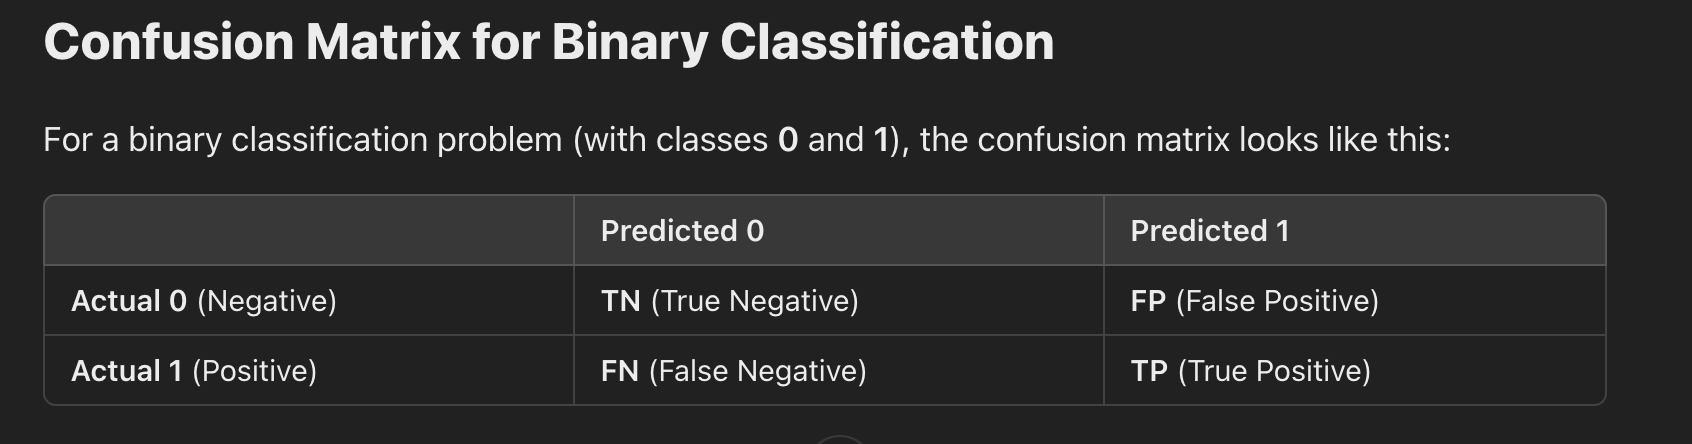

In [80]:
# Default threshold (0.166)
y_pred_default = (y_scores >= 0.5).astype(int)
y_pred_custom = (y_scores >= optimal_threshold).astype(int)
# Compare confusion matrices
print("Confusion Matrix (Default Threshold 0.5):\n", confusion_matrix(true_train_labels, y_pred_default))
print("\nConfusion Matrix (Custom Threshold {:.4f}):\n".format(optimal_threshold), confusion_matrix(true_train_labels, y_pred_custom))


Confusion Matrix (Default Threshold 0.5):
 [[12536  1386]
 [  830 52121]]

Confusion Matrix (Custom Threshold 0.9834):
 [[13783   139]
 [26174 26777]]


In [81]:
balanced_acc = balanced_accuracy_score(true_train_labels, y_pred_default)
print("Balanced Accuracy train default threshold 0.5:", balanced_acc)

Balanced Accuracy train default threshold 0.5: 0.9423852345473746


In [82]:
balanced_acc = balanced_accuracy_score(true_train_labels, y_pred_custom)
print("Balanced Accuracy train custom treshold 0.9834:", balanced_acc)

Balanced Accuracy train custom treshold 0.9834: 0.7478548728922052


In [84]:
y_test_pred = xgb_clf.predict_proba(X_test)
y_test_scores = np.array([max(probs[3:]) / (max(probs[:3]) + max(probs[3:])) for probs in y_test_pred])
y_pred_test_custom = (y_test_scores >= optimal_threshold).astype(int)

balanced_acc = balanced_accuracy_score(true_labels, y_pred_test_custom)
print("Balanced Accuracy test custom treshold 0.9834:", balanced_acc)

Balanced Accuracy test custom treshold 0.9834: 0.6256578880777108


In [85]:
print("Confusion Matrix Test values (Custom Threshold {:.4f}):\n".format(optimal_threshold), confusion_matrix(true_labels, y_pred_test_custom))

Confusion Matrix Test values (Custom Threshold 0.9834):
 [[ 5687   201]
 [16018  6399]]


### Treshold test

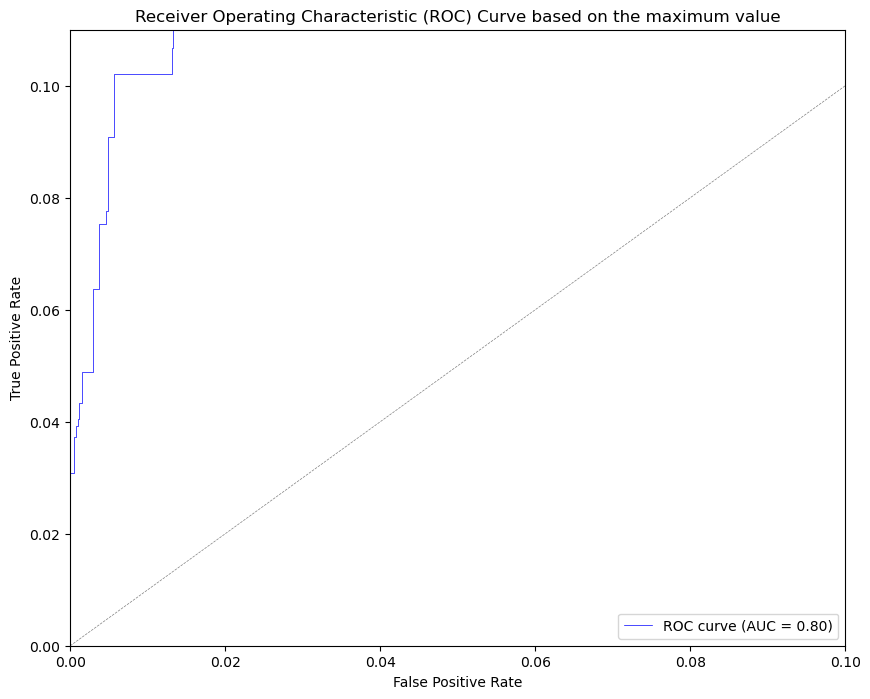

In [87]:
raw_scores = xgb_clf.predict_proba(X_test)
y_scores_test = np.array([max(probs[3:]) / (max(probs[:3]) + max(probs[3:])) for probs in raw_scores])

fpr, tpr, _ = roc_curve(true_labels, y_scores_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=0.5, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0.0, 1.0], [0.0, 1.0], lw=0.5,color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 0.1])
plt.ylim([0.0, 0.11])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve based on the maximum value')
plt.legend(loc='lower right')
plt.show()

In [90]:
from sklearn.metrics import roc_curve
import numpy as np

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, y_scores_test)

valid_indices = np.where(fpr <= 0.01)[0]

optimal_idx = valid_indices[np.argmax(tpr[valid_indices])]
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}, TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

Optimal Threshold: 0.9951, TPR: 0.1021, FPR: 0.0056


In [91]:
# Default threshold (0.166)
y_pred_default = (y_scores_teset >= 0.5).astype(int)
y_pred_custom = (y_scores_teset >= optimal_threshold).astype(int)

# Compare confusion matrices
print("Confusion Matrix (Default Threshold 0.5):\n", confusion_matrix(true_labels, y_pred_default))
print("\nConfusion Matrix (Custom Threshold {:.4f}):\n".format(optimal_threshold), confusion_matrix(true_labels, y_pred_custom))

Confusion Matrix (Default Threshold 0.5):
 [[ 2974  2914]
 [ 2152 20265]]

Confusion Matrix (Custom Threshold 0.9951):
 [[ 5855    33]
 [20128  2289]]
